In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

2022-04-29 17:59:44.201806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 17:59:44.201869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Open data
data_file = open('Data.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer(char_level = False)

data = data_file.lower().splitlines()

data = list(filter(lambda x: x != '##', data))

new_data = data

for paragraph in range(len(data)):
    sentences = data[paragraph].split('.')
    if sentences != ' ':
        new_data[paragraph] = sentences
    
    
#data = data = np.vstack([[new_data[0:-1]]]).T
data = new_data
#data

In [3]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'
new_data = data
max_sentence_length = 0

for paragraph in range(len(data)):
    para = data[paragraph]

    for sentence in range(len(para)):
        para[sentence] = start_token + para[sentence]
        para[sentence] = para[sentence] + end_token

        num_words =  len(para[sentence].split())
        if max_sentence_length < num_words:
            max_sentence_length = num_words

    new_data[paragraph] = para
      

data = new_data
#data

In [4]:
def Encode_Inputs(data, max_sentence_length):
    input_sequences = list()
    output_sequences = list()
    
    for paragraph in range(len(data)):
        para = data[paragraph]

        tokenized_sentence = para
        tokenizer.fit_on_texts(tokenized_sentence)

        #Transforms sentences into set of integers from the dictionary
        tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)

        #Pad sequences to length of max_length
        tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = max_sentence_length, padding ='post', value = 0)
        total_words = len(tokenizer.word_index) + 1    

        roll_amount = tokenized_sentence.shape[1] * (tokenized_sentence.shape[0]-1)
        output_tokens = np.array(np.roll(tokenized_sentence, roll_amount))
        output_tokens[-1] = 0

        input_sequences.append(tokenized_sentence)
        output_sequences.append(output_tokens)

    input_sequences = np.vstack(input_sequences)
    output_sequences = np.vstack(output_sequences)
    
    return input_sequences, output_sequences, total_words

In [5]:
def Decode_Inputs(input_sequences):

    data = tokenizer.sequences_to_texts(input_sequences)
    return data

In [18]:
input_sequences, output_sequences, total_words = Encode_Inputs(data, max_sentence_length)
post_output_sequences = output_sequences[:,0:][:]
print(total_words)
decoded = Decode_Inputs(output_sequences)
print(input_sequences.shape)
print(output_sequences.shape)
print(post_output_sequences.shape)
print('Input:', Decode_Inputs(input_sequences)[0])
print('Target:', Decode_Inputs(post_output_sequences)[0])
input_sequences[0]

4547
(1847, 88)
(1847, 88)
(1847, 88)
Input: start the important thing is not to stop questioning end
Target: start curiosity has its own reason for existence end


array([   1,    3,  263,  206,   12,   21,    5,  880, 2166,    2,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [19]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer_Block, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [20]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [21]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [27]:
input_sequences[0]

array([   1,    3,  263,  206,   12,   21,    5,  880, 2166,    2,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [28]:
Decode_Inputs(input_sequences)[0]

'start the important thing is not to stop questioning end'

In [29]:
#Variables
embed_dim = 128
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 8 
ff_dim = 16
dropout = 0.15

encoder_stack = 2
decoder_stack = 2

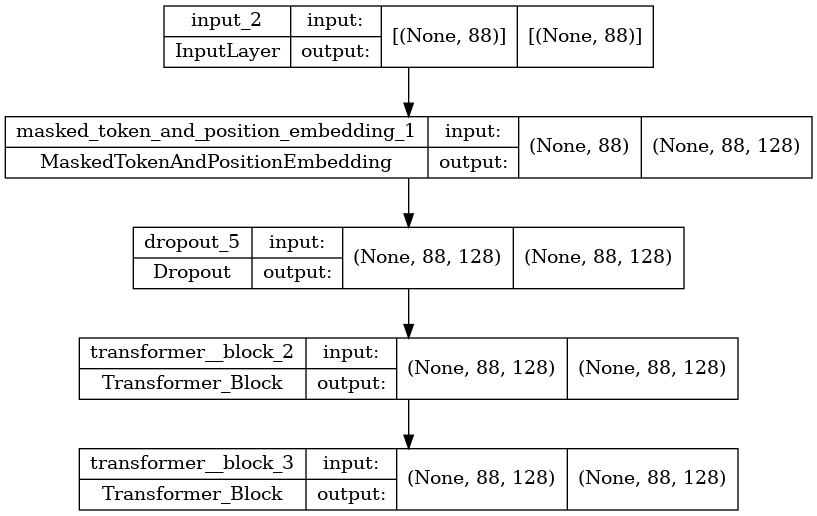

In [30]:
#Encoder

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1:])
encoder = MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout_layer = keras.layers.Dropout(dropout, noise_shape=encoder.shape[:-1]+(1,))(encoder)
encoder = dropout_layer

for i in range(encoder_stack):
      encoder = Transformer_Block(embed_dim, num_heads, ff_dim, dropout)(encoder)                                                                    

encoder_model = keras.Model(input_layer, encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

In [31]:
# result = encoder_model.predict(input_sequences)
# print('Input:', Decode_Inputs(result.argmax(0-1)))

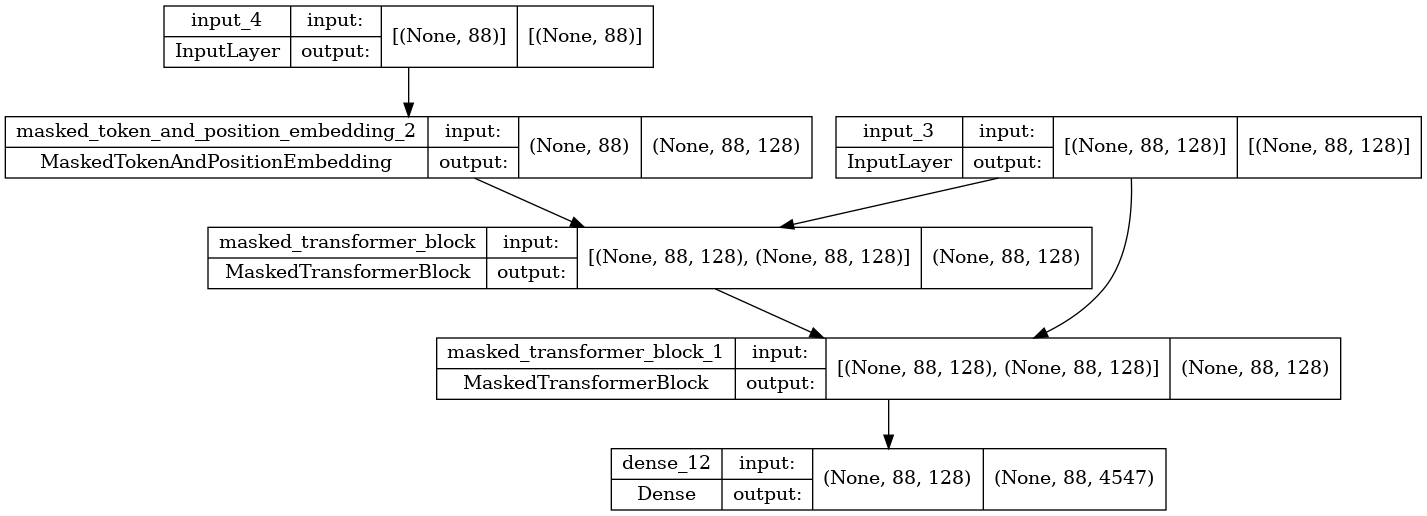

In [32]:
#Decoder 

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1:])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(total_words)(decoder)

decoder_model = keras.Model([input_layer, encoder_input_layer], linear_layer)
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

In [33]:
# context = encoder_model.predict(input_sequences)
# token = np.zeros(output_sequences.shape)
# token[:,0] = 1 
# for x in range(output_sequences.shape[1]-1):
#     result = decoder_model.predict([token,context]).argmax(-1)
#     token[:,x+1] = result[:,x]
# result = decoder_model.predict([token,context])
# print('Input:', Decode_Inputs(result.argmax(0-1)))

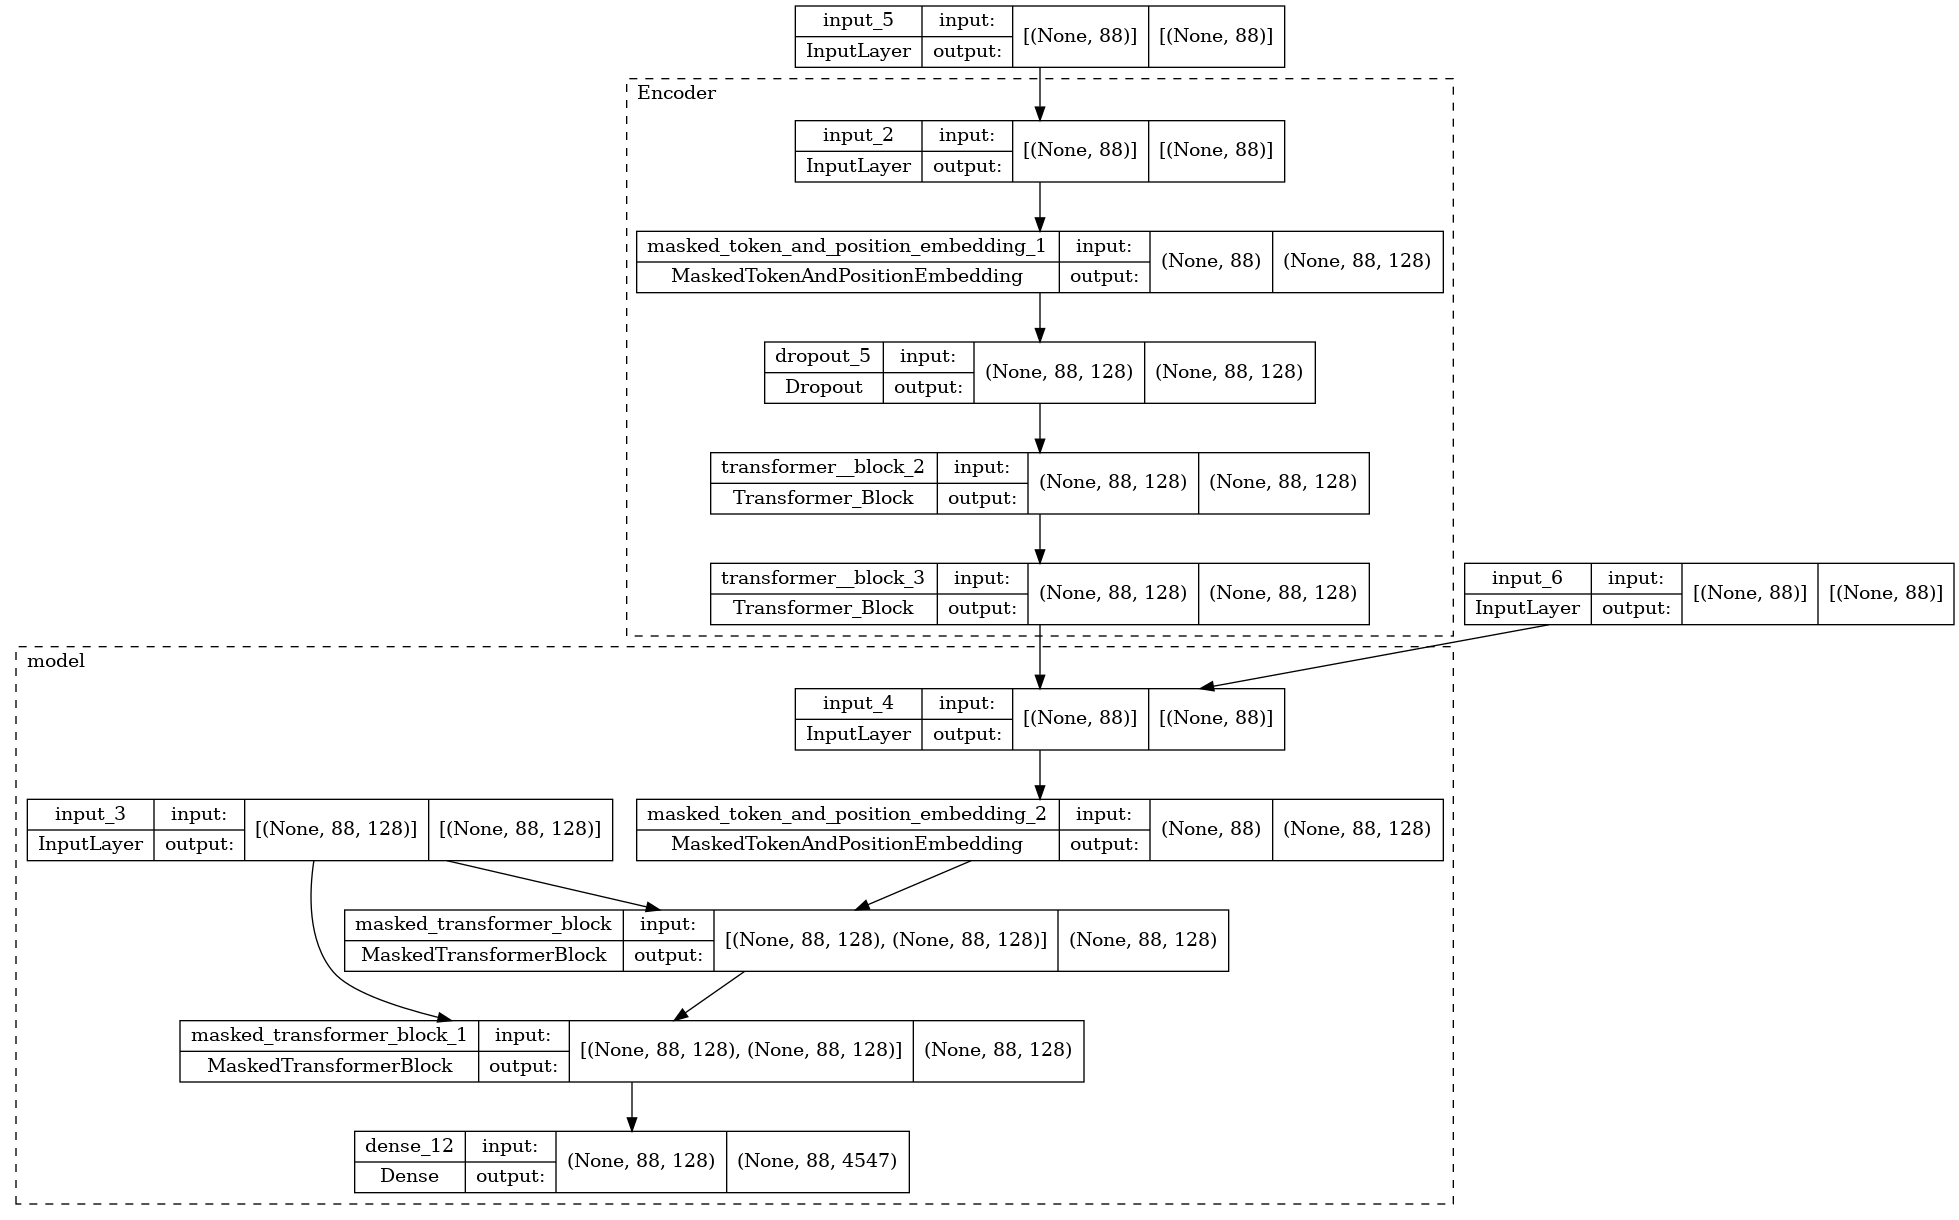

In [34]:
sequences = keras.layers.Input(encoder_model.input_shape[1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])

transformer = decoder_model([targets, encoder_model(sequences)])
transformer = keras.Model([sequences, targets], transformer)

keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [35]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 88, 128)      1657888     ['input_5[0][0]']                
                                                                                                  
 model (Functional)             (None, 88, 4547)     3299427     ['input_6[0][0]',                
                                                                  'Encoder[0][0]']          

In [37]:
batch_size = 10
epochs = 3

history = transformer.fit([input_sequences, output_sequences], post_output_sequences, batch_size=batch_size, epochs=epochs, validation_data=([input_sequences, output_sequences], post_output_sequences), verbose=1)

Epoch 1/3
185/185 [==============================] - 180s 943ms/step - loss: 3.4800 - MaskedSparseCategoricalAccuracy: 0.6488 - val_loss: 1.2891 - val_MaskedSparseCategoricalAccuracy: 0.9433
Epoch 2/3
185/185 [==============================] - 169s 917ms/step - loss: 0.9370 - MaskedSparseCategoricalAccuracy: 0.9349 - val_loss: 0.4895 - val_MaskedSparseCategoricalAccuracy: 0.9927
Epoch 3/3
185/185 [==============================] - 169s 915ms/step - loss: 0.4207 - MaskedSparseCategoricalAccuracy: 0.9946 - val_loss: 0.2149 - val_MaskedSparseCategoricalAccuracy: 1.0000


In [38]:
print('Training Accuracy:',transformer.evaluate([input_sequences, output_sequences] ,post_output_sequences)[1]*100.0,'%')

58/58 [==============================] - 46s 790ms/step - loss: 0.2154 - MaskedSparseCategoricalAccuracy: 1.0000
Training Accuracy: 100.0 %


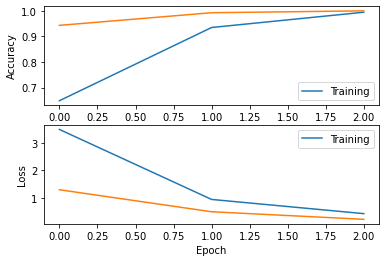

In [39]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='upper right') 

In [40]:
output_sequences[0]

array([   1, 2167,   47,  120,  415,  277,   14, 1091,    2,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [41]:
i = 1
print('Input:',input_sequences[i])
print('Output:', post_output_sequences[i])

Input: [   1 2167   47  120  415  277   14 1091    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
Output: [   1   38  145  557   23   15    8 2168   54   40 2169    3 2170    4
 2171    4  126    4    3  558 1466    4 1092    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [42]:
print('Input:', Decode_Inputs(input_sequences)[i])
print('Target:', Decode_Inputs(post_output_sequences)[i])

Input: start curiosity has its own reason for existence end
Target: start one cannot help but be in awe when he contemplates the mysteries of eternity of life of the marvelous structure of reality end


In [48]:
# Teacher-forcing
result = transformer.predict([input_sequences[i:i+1],output_sequences[i:i+1]])
result.argmax(-1)[0]
Decode_Inputs(result.argmax(-1))

['start one cannot help but be in awe when he contemplates the mysteries of eternity of life of the marvelous structure of reality end without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without without']

In [49]:
MaskedSparseCategoricalAccuracy(post_output_sequences[i:i+1],result).numpy()*100.0

100.0

In [ ]:
context = encoder_model.predict(input_sequences)
token = np.zeros(output_sequences.shape)
token[:,0] = 1 
for x in range(post_output_sequences.shape[1]-1):
    result = decoder_model.predict([token,context]).argmax(-1)
    token[:,x+1] = result[:,x]
result = decoder_model.predict([token,context])
print('Input:', Decode_Inputs(result.argmax(0-1))[0])

In [ ]:
MaskedSparseCategoricalAccuracy(post_output_sequences[i:i+1],result).numpy()*100.0